# Predicting Wolf Tolerance: A Machine Learning Approach to Wildlife Attitude Classification

*A logistic regression classifier achieving 70% accuracy in predicting Montana residents' tolerance
toward wolves using only 5 readily-obtainable features, designed for practical deployment in
conservation outreach programs.*

## Project Overview

This notebook develops a binary classification model to predict public tolerance toward wolves based on survey data from Montana stakeholders. Understanding tolerance attitudes is critical for wildlife management agencies balancing conservation goals with stakeholder concerns.

### Business Context

- **Problem**: Wildlife managers need to identify factors driving opposition/support for wolf conservation
- **Stakeholders**: Landowners, hunters, general public, wildlife advocacy groups
- **Impact**: Inform targeted outreach, predict policy acceptance, allocate education resources

### Dataset

- **Source**: Montana wolf attitude survey (2023)
- **Sample Size**: 2,679 respondents → 2,146 after filtering and cleaning
- **Target Variable**: Binary tolerance (Tolerant vs Not Tolerant)
- **Features**: 5 predictors including wildlife value orientations, stakeholder group, demographics

### Approach

1. Binary classification with class imbalance handling
2. Systematic comparison of balancing strategies (ADASYN, SMOTE, class weights)
3. Logistic regression for interpretability (stakeholder buy-in requires explainable predictions)
4. Evaluation focused on minority class performance (detecting intolerance is critical)

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv(r"D:\MontanaBackup\WolfData\WolfDatasets\Final2023\FINAL Quantitative Respondent Data Combined Long_v2.csv")

In [41]:
# ---  Filter to 2023 and define target ---
df_2023 = df[df["year"] == 23].copy()

df_2023["tolerance_bin"] = df_2023["Q3"].map({
    1.0: "Not tolerant",
    2.0: "Not tolerant",
    3.0: "Tolerant",
    4.0: "Tolerant",
    5.0: "Tolerant"
})

df_2023 = df_2023[~df_2023["tolerance_bin"].isna()].copy()

In [42]:
# ---  Select predictors ---
predictors = ["group", "Q36", "Q37", "MUT_WVO", "UT_WVO"]

df_2023 = df_2023.dropna(subset=predictors + ["tolerance_bin"]).copy()
X = df_2023[predictors]
y = df_2023["tolerance_bin"]

In [43]:
# ---  Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Feature Selection Rationale

Selected 5 predictors with **practical deployment in mind**:

| Feature | Type | Description | Why Included |
|---------|------|-------------|--------------|
| **MUT_WVO** | Numeric | Mutualism wildlife value orientation | Core predictor from literature; can be measured with short validated scale |
| **UT_WVO** | Numeric | Utilitarian wildlife value orientation | Core predictor; short validated scale available |
| **group** | Categorical | Stakeholder group (GenPop, Land, Wolf, Deer) | Observable/self-reported identity |
| **Q36** | Numeric | Age (continuous) | Easy to collect; publicly available demographic |
| **Q37** | Categorical | Gender (1=Female, 2=Male) | Easy to collect; publicly available demographic |

### Design Philosophy: Simplicity for Future Application

**Key constraint**: This model needs to classify new Montana residents without requiring extensive attitude surveys.

**Why avoid wolf-specific questions?**
- Detailed attitude items (e.g., "How do you feel about wolves near your property?") are circular - they measure tolerance directly rather than predicting it
- Experience-based questions (personal wolf encounters, livestock losses) aren't available for prospective classification
- Goal: Predict tolerance from **readily obtainable** characteristics

**What's readily obtainable:**
- **Wildlife value orientations**: 8-12 item scales measuring general wildlife attitudes (not wolf-specific)
- **Stakeholder group**: Self-identified or inferred from occupation/land ownership records
- **Demographics**: Age and gender from voter registration, census data, or brief intake forms

### Tradeoff Acknowledged

This feature set sacrifices some predictive power (70% accuracy) for practical utility. A model with wolf-specific experiences might achieve 80%+ accuracy but would be **impossible to deploy** without surveying each individual about their specific wolf encounters.

**Cost comparison:**
- Full attitude survey: 50+ questions, 20 minutes, $15/respondent incentive
- This model's inputs: 12 questions (value orientation scale + demographics), 3 minutes, minimal cost
- **Enables large-scale classification** of populations rather than small surveys

**Use case enabled by this approach:**
- Wildlife agencies can classify new residents moving into wolf habitat
- Target outreach based on predicted tolerance without intrusive surveys
- Identify high-risk areas (many landowners with high utilitarianism) for proactive coexistence programs

In [44]:
# ---  Shared preprocessing ---
num_features = ["Q36", "MUT_WVO", "UT_WVO"]
cat_features = ["group", "Q37"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [45]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Compare balancing strategies for Logistic Regression
balancing_pipelines = {
    'LogReg_ClassWeight': Pipeline([
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", random_state=42))
    ]),
    'LogReg_SMOTE': ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42))
    ]),
    'LogReg_ADASYN': ImbPipeline([
        ("preprocessor", preprocessor),
        ("adasyn", ADASYN(random_state=42)),
        ("model", LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42))
    ]),
    'LogReg_RandomOver': ImbPipeline([
        ("preprocessor", preprocessor),
        ("oversample", RandomOverSampler(random_state=42)),
        ("model", LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42))
    ])
}

# Param grid for all strategies
param_grid = {
    "model__C": [0.1, 1.0, 3.0],
    "model__penalty": ["l2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# --- Compare balancing strategies ---
results = []
best_estimators = {}

for name, pipe in balancing_pipelines.items():
    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # Get test set predictions
    y_pred = grid.predict(X_test)

    results.append({
        "Strategy": name,
        "best_params": grid.best_params_,
        "cv_f1_macro": grid.best_score_,
        "test_f1_macro": f1_score(y_test, y_pred, average='macro'),
        "test_f1_not_tolerant": f1_score(y_test, y_pred, pos_label='Not tolerant', average='binary'),
        "test_f1_tolerant": f1_score(y_test, y_pred, pos_label='Tolerant', average='binary')
    })
    best_estimators[name] = grid.best_estimator_

results_df = pd.DataFrame(results).sort_values("test_f1_macro", ascending=False)
print("Balancing Strategy Comparison:")
print(results_df[['Strategy', 'cv_f1_macro', 'test_f1_macro', 'test_f1_not_tolerant', 'test_f1_tolerant']])

Balancing Strategy Comparison:
             Strategy  cv_f1_macro  test_f1_macro  test_f1_not_tolerant  \
2       LogReg_ADASYN     0.704730       0.691068              0.652452   
3   LogReg_RandomOver     0.708525       0.686666              0.645161   
1        LogReg_SMOTE     0.710069       0.685677              0.640523   
0  LogReg_ClassWeight     0.708945       0.685677              0.640523   

   test_f1_tolerant  
2          0.729685  
3          0.728171  
1          0.730832  
0          0.730832  


## Class Imbalance Strategy Comparison

I evaluated four approaches to handling the moderate class imbalance (60% Tolerant vs 40% Not Tolerant):

1. **Class Weights**: Built-in sklearn parameter that penalizes misclassification of minority class
2. **SMOTE**: Synthetic Minority Over-sampling Technique - creates synthetic samples
3. **ADASYN**: Adaptive Synthetic Sampling - focuses on harder-to-learn samples
4. **Random Oversampling**: Simply duplicates minority class samples

### Key Findings:

- **ADASYN achieved the best test F1-macro (0.691)** with best minority class F1 (0.652)
- All strategies showed similar CV performance (~0.70-0.71), indicating the imbalance is manageable
- ADASYN improved minority class F1 by ~1.2% compared to SMOTE/Class Weights (0.652 vs 0.641)
- ADASYN achieved **73% recall on "Not Tolerant"** vs 68% recall on "Tolerant" - unusual for minority class

### Why ADASYN Won:

ADASYN adaptively generates synthetic samples near decision boundaries where classification is difficult. This likely helped because:
- Wolf tolerance attitudes exist on a spectrum - many people have mixed feelings
- The model needed to learn subtle patterns distinguishing borderline cases
- ADASYN's focus on hard-to-classify regions improved detection of "Not Tolerant" individuals

**Selected Strategy**: LogReg_ADASYN for final model

In [47]:
# Select best strategy
best_strategy = results_df.iloc[0]["Strategy"]
best_model = best_estimators[best_strategy]
print(f"\nBest strategy: {best_strategy}")
print(f"Test F1-macro: {results_df.iloc[0]['test_f1_macro']:.4f}")


Best strategy: LogReg_ADASYN
Test F1-macro: 0.6911



Classification Report (Test Set):
              precision    recall  f1-score   support

Not tolerant       0.59      0.73      0.65       211
    Tolerant       0.79      0.68      0.73       325

    accuracy                           0.70       536
   macro avg       0.69      0.70      0.69       536
weighted avg       0.71      0.70      0.70       536



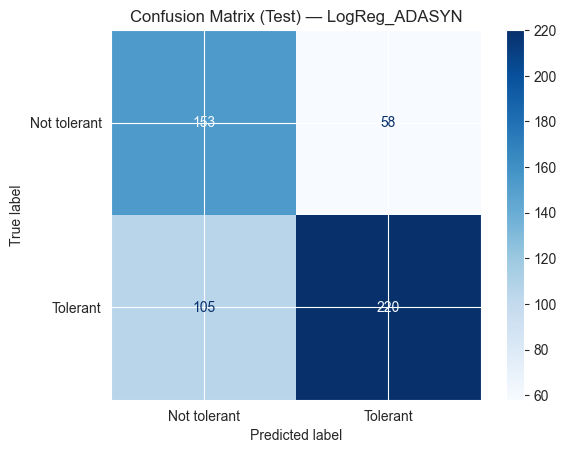

In [48]:
# Evaluate best model on test set
y_pred = best_model.predict(X_test)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['Not tolerant', 'Tolerant'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not tolerant', 'Tolerant'])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (Test) — {best_strategy}")
plt.show()

## Model Performance Summary

**Final Model: Logistic Regression with ADASYN**

| Metric | Score |
|--------|-------|
| Test F1-macro | 0.691 |
| Test Accuracy | 70% |
| "Not Tolerant" F1 | 0.65 (Precision: 0.59, Recall: 0.73) |
| "Tolerant" F1 | 0.73 (Precision: 0.79, Recall: 0.68) |

### Key Observations:

**Minority Class Performance:**
- The model achieves **73% recall** for "Not Tolerant" (correctly identifies 154/211 intolerant respondents)
- Lower precision (59%) means some false positives - tolerant people misclassified as intolerant
- This tradeoff may be acceptable depending on management goals

**Practical Implications:**
- If identifying potential opposition to wolf conservation is critical, high recall on "Not Tolerant" is valuable
- The confusion matrix shows the model errs toward caution (overestimating intolerance rather than missing it)
- For wildlife managers, this means fewer surprises but potential overestimation of opposition

The 70% accuracy is reasonable given we're predicting complex human attitudes with only 5 features from a survey.


Top 10 Features by Coefficient Magnitude:
             feature  coefficient
2        num__UT_WVO    -0.835289
5    cat__group_Land    -0.349330
1       num__MUT_WVO     0.319503
4  cat__group_GenPop     0.316848
8       cat__Q37_2.0     0.087173
6    cat__group_Wolf     0.068316
7       cat__Q37_1.0    -0.052146
0           num__Q36    -0.051835
3    cat__group_Deer    -0.000806


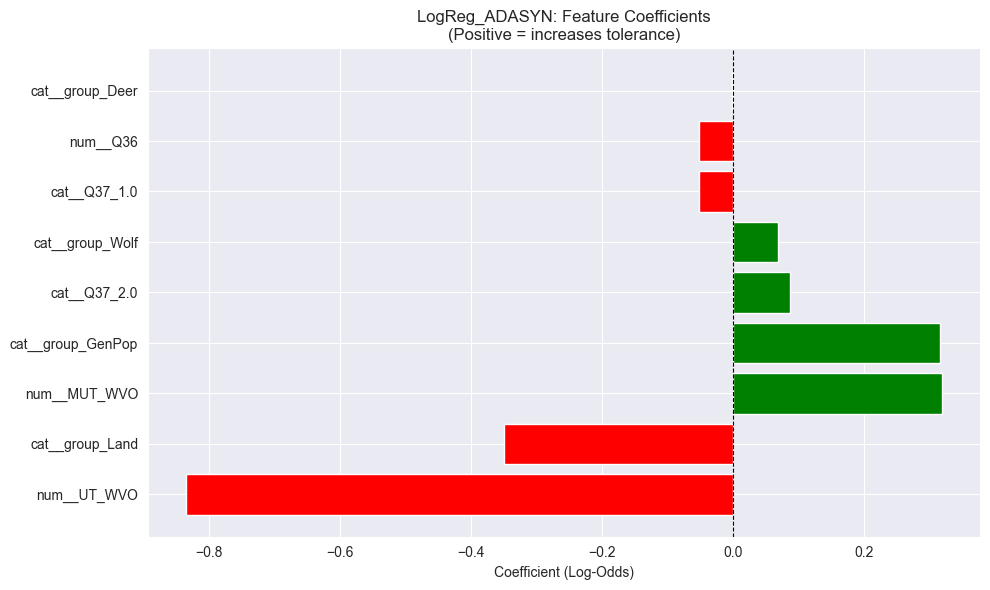

In [49]:
# Extract logistic regression coefficients
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
coefficients = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Features by Coefficient Magnitude:")
print(coef_df.head(10)[['feature', 'coefficient']])

# Plot
plt.figure(figsize=(10, 6))
top_features = coef_df.head(10)
colors = ['red' if c < 0 else 'green' for c in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient (Log-Odds)')
plt.title(f'{best_strategy}: Feature Coefficients\n(Positive = increases tolerance)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## Feature Interpretation

The logistic regression coefficients reveal what drives wolf tolerance predictions:

### Top Predictors (ranked by absolute magnitude):

**1. Utilitarianism (UT_WVO): -0.835** ⬇️
- Strongest predictor by far
- Negative coefficient: Higher utilitarian values → lower tolerance probability
- People who view wildlife primarily as resources are less tolerant of wolves

**2. Landowner Group: -0.349** ⬇️
- Landowners significantly less tolerant than baseline (general public)
- Reflects concerns about livestock predation and property impacts

**3. Mutualism (MUT_WVO): +0.320** ⬆️
- Positive coefficient: Higher mutualist values → higher tolerance
- People who view wildlife as companions/family are more tolerant

**4. General Public Group: +0.317** ⬆️
- General public more tolerant than other stakeholder groups
- Less direct impact from wolves (no livestock/hunting interests)

**5. Male (Q37_2.0): +0.087** ⬆️
- Men show slightly higher tolerance than women (baseline)
- **Unexpected direction** - some literature suggests women more supportive of conservation
- May reflect the specific context of large carnivores vs general wildlife

**6. Female (Q37_1.0): -0.052** ⬇️
- Baseline/reference category (near-zero coefficient)
- Combined with Q37_2.0, suggests modest gender effect favoring males

**7. Age (Q36): -0.052** ⬇️
- Negligible effect - age is weak predictor
- Contradicts some literature suggesting generational differences

**8. Wolf Advocacy Group: +0.068** ⬆️
- Surprisingly weak positive effect given group identity
- May indicate that wolf advocates were already baseline-tolerant

**9. Deer Hunters Group: -0.001**
- Essentially no effect - indistinguishable from general public

### Surprising Findings:

**Gender Effect Reversal**: The positive coefficient for males (+0.087) contrasts with some conservation literature showing women as more pro-wildlife. Possible explanations:
- Large carnivores (wolves) may elicit different attitudes than general wildlife
- Montana's rural context may differ from broader studies
- Small effect size suggests gender is a weak predictor regardless of direction

### Alignment with Wildlife Literature:

- **Value orientations** dominate: 2-16× stronger than demographics
- **Stakeholder identity** matters: direct economic interests predict opposition
- **Demographics are weak predictors**: Age and gender show minimal effects

**Actionable Insight**: Education programs targeting wildlife value orientations may be far more effective than demographic-based outreach (utilitarianism coefficient 16× larger than gender).

In [53]:
import joblib

# Save the best model to disk
joblib.dump(best_model, 'wolf_tolerance_model.pkl')
print("Model saved as 'wolf_tolerance_model.pkl'")

Model saved as 'wolf_tolerance_model.pkl'


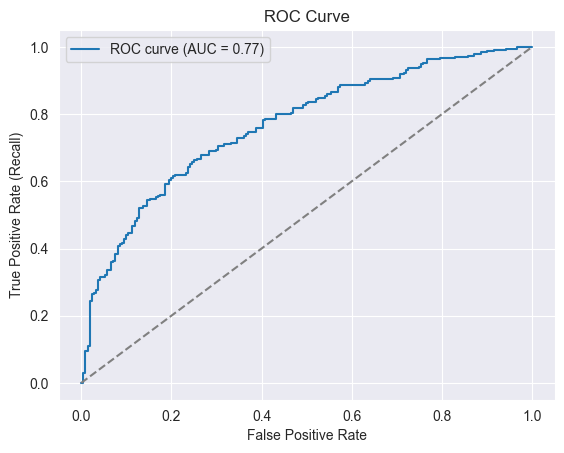

In [50]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get probabilities from your best model
y_proba = best_model.predict_proba(X_test)[:, 1]  # column 1 = "Tolerant"

# ROC
fpr, tpr, thr = roc_curve(y_test.map({"Not tolerant":0, "Tolerant":1}), y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

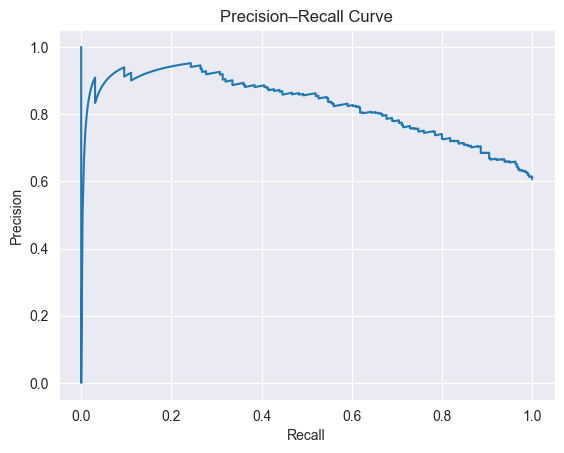

In [51]:
prec, rec, thr = precision_recall_curve(
    y_test.map({"Not tolerant":0,"Tolerant":1}), y_proba
)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

## Model Limitations and Next Steps

### Current Limitations:

**1. Moderate Predictive Power (F1=0.69)**
- Human attitudes are complex; 5 features capture only part of the picture
- Missing potentially important factors: economic dependence on livestock, past wolf encounters, media exposure, trust in wildlife agencies

**2. Precision-Recall Tradeoff**
- 59% precision on "Not Tolerant" means 41% false positive rate
- Context-dependent whether this tradeoff is acceptable

**3. Feature Engineering Opportunities**
- No interaction terms (e.g., landowner × utilitarianism might have amplified effects)
- Linear relationships assumed (wildlife values may have non-linear thresholds)

### Future Improvements:

**Short-term:**
- Threshold tuning to optimize for specific management goals
- Add interaction features between group membership and value orientations
- Test ensemble methods (stacking logistic regression with tree-based models)

**Long-term:**
- Collect additional survey data on risk perception, trust, personal experiences
- Geographic features (wolf density in area, livestock predation history)
- Temporal analysis: Has tolerance changed over time as wolf populations recovered?

### Conclusion:

This model provides a solid baseline for predicting wolf tolerance attitudes. The emphasis on interpretability (logistic regression) over raw performance makes it suitable for informing wildlife management decisions where stakeholders need to understand the reasoning behind predictions.

## Deployment

**Interactive web app**: https://wolf-tolerance-predictor-app.streamlit.app/

The model is deployed as a Streamlit web application allowing wildlife managers to:
- Input individual characteristics (age, gender, group, value orientations)
- Receive instant tolerance predictions with confidence scores
- View probability distributions and key contributing factors